#APTAS

In [1]:
import math
from typing import List, Tuple

try:
  import pulp
except ImportError:
  __import__('subprocess').check_call([__import__('sys').executable, '-m', 'pip', 'install', 'pulp'], stdout=None,
                                      stderr=None);
from collections import Counter
from itertools import combinations
import sys

sys.setrecursionlimit(20000)

# item indices
WIDTH = 0
HEIGHT = 1

class APTAS:
  aleph = None

  def __init__(self, items: List[Tuple[float, float]], epsilon: float):
    self.items = items
    self.epsilon = epsilon

  # part a
  def decomposition(self):
    """Find optimal f and group items into A_i sets.
   Decomposition:

(a.1) Guess the integer ff (1≤f≤t:=1/ε) and for i∈I ⁣ ⁣Ni∈IN remove all the items
   with height in (εf+it,εf+it−1).
(a.2) Let AiAi​ be the set of the items with heights in [εf+it−1,εf+(i−1)t] for each
   i∈I ⁣ ⁣Ni∈IN. Form the shelves in the final solution by considering separately each set Ai​.
   """
    t = math.ceil(1 / self.epsilon)
    best_profit = 0
    opt_f = None
    opt_A = []

    # guess f by bruteforcing
    for f in range(1, t + 1):
      A = [[] for _ in range(t)]
      for item in self.items:
        h = item[HEIGHT]
        for i in range(t):
          lower = self.epsilon ** (f + i * t - 1)
          upper = self.epsilon ** t if i == 0 else self.epsilon ** (f + (i - 1) * t)
          if lower <= h <= upper:
            A[i].append(item)
            break

      profits = [sum(w * h for w, h in A_i) for A_i in A]
      if not profits:
        continue
      # find the idx of the smallest profit
      min_idx = profits.index(min(p for p in profits if p > 0) if any(p > 0 for p in profits) else 0)
      current_A = [A_i for idx, A_i in enumerate(A) if idx != min_idx]  # remove height group with smallest profit
      current_profit = sum(w * h for A_i in current_A for w, h in A_i)
      if current_profit > best_profit:  # take f that results in highest profit
        best_profit = current_profit
        opt_f = f
        opt_A = current_A

    return opt_f, opt_A

  # part b
  def subdivide_and_melt(self, f: int, A: List[List[Tuple[float, float]]]):
    """Divide items into wide and thin; return thin items separately.
   Item Subdivision and Vertical Melting: For each set Ai​, i∈I ⁣ ⁣Ni∈IN:
(b.1) Separate wide items (having width at least εtεt) from thin items (having width smaller than εtεt).
(b.2) Allow thin items to be cut vertically.
   """
    t = math.ceil(1 / self.epsilon)
    wide_groups = []
    thin_items_groups = []
    for A_i in A:
      wide_items = [item for item in A_i if item[WIDTH] >= self.epsilon ** t]
      thin_items = [item for item in A_i if item[WIDTH] < self.epsilon ** t]
      wide_groups.append(wide_items)
      thin_items_groups.append(thin_items)
    return wide_groups, thin_items_groups

  # part c
  def nfdh_pack(self, items: List[Tuple[float, float]], H: float) -> bool:
    """Check if NFDH can pack all items within height H."""
    sorted_items = sorted(items, key=lambda x: -x[1])
    shelves = []
    current_shelf_items = []
    current_shelf_width = 0
    total_height = 0
    for item in sorted_items:
      if current_shelf_width + item[0] > 1:
        if current_shelf_items:
          shelf_height = max(it[1] for it in current_shelf_items)
          if total_height + shelf_height > H:
            return False
          shelves.append(current_shelf_items)
          total_height += shelf_height
        current_shelf_items = [item]
        current_shelf_width = item[0]
      else:
        current_shelf_items.append(item)
        current_shelf_width += item[0]
    if current_shelf_items:
      shelf_height = max(it[1] for it in current_shelf_items)
      if total_height + shelf_height > H:
        return False
      shelves.append(current_shelf_items)
    return True

  def low_shelves(self, wide_groups: List[List[Tuple[float, float]]],
                  thin_items_groups: List[List[Tuple[float, float]]], f: int):
    """
    Definition of Low Shelves: For each set AiAi​, i∈I ⁣ ⁣N∖{0}i∈IN∖{0}:

    (c.1) Round-up all heights to the nearest multiple of εf+itεf+it, letting h‾1,…,h‾gih1​,…,hgi​​ be the distinct heights after rounding and n1,…,ngin1​,…,ngi​​ the numbers of items of each height. For the profit (area) computation, consider rounded-down heights.
    Comment: See Lemma 4.

    (c.2) For each vector (m1,…,mgi)(m1​,…,mgi​​) such that 0≤mj≤nj (j=1,…,gi)0≤mj​≤nj​(j=1,…,gi​) and H:=∑j=1gimjh‾j≤1H:=∑j=1gi​​mj​hj​≤1, if not all items in AiAi​ can be packed in shelves of total height at most HH by NFDH:

        (c.2.1) Preprocess the wide items in AiAi​.
        Comment: See Section 2.1.1 and Lemma 6.

        (c.2.2) Round the widths of the preprocessed items with the same height after Step (c.1) by linear grouping. For the profit (area) computation, consider rounded-down widths.
        Comment: See Section 2.1.2 and Lemma 7.

        (c.2.3) Pack some items in AiAi​ in shelves of overall height at most HH and overall maximum profit by enumeration of the packings of wide items in AiAi​ combined with the solution of (1)-(6).
    """
    t = math.ceil(1 / self.epsilon)
    pi_list = []
    for i in range(1, len(wide_groups)):
      wide = wide_groups[i]
      thin = thin_items_groups[i]
      if not wide and not thin:
        pi_list.append({})
        continue

      # round heights to format (org_w, org_h, rounded_up_h, rounded_down_h)
      heights_info = [
        (w, h, math.ceil(h / self.epsilon ** (f + i * t)) * self.epsilon ** (f + i * t),
          math.floor(h / self.epsilon ** (f + i * t)) * self.epsilon ** (f + i * t))
        for w, h in wide
      ]
      hc_list = [hc for _, _, hc, _ in heights_info]
      counts_map = Counter(hc_list)
      heights_i = sorted(counts_map.keys(), reverse=True)
      counts_i = [counts_map[hc] for hc in heights_i]

      def enumerate_m(heights, counts, max_height=1.0):
        g = len(heights)
        current = [0] * g

        def dfs(j, remaining_height):
          if j == g:
            yield tuple(current)
            return
          max_mj = min(counts[j], int(remaining_height // heights[j]))
          for mj in range(max_mj + 1):
            current[j] = mj
            yield from dfs(j + 1, remaining_height - mj * heights[j])
          current[j] = 0

        yield from dfs(0, max_height)

      pi = {}
      # generate all combinations of m_j
      for m_vec in enumerate_m(heights_i, counts_i):
        item_list = []
        for idx, m_j in enumerate(m_vec):
          h_j = heights_i[idx]
          count = 0
          for w, _, hc, _ in heights_info:
            if hc == h_j and count < m_j:
              item_list.append((w, hc))
              count += 1
        total_height = sum(m_j * heights_i[idx] for idx, m_j in enumerate(m_vec))
        if self.nfdh_pack(item_list, total_height): # case 1: nfdh fits, compute profit directly
          profit = sum(w * h for w, h in item_list)
          pi[total_height] = max(pi.get(total_height, 0), profit)
        else: # case 2: nfdg doesn't fit, proceed with preprocessing, grouping, and MIP
          # (c.2.1) Preprocess wide items for each height class
          preprocessed_items = []
          H_limit = total_height
          limit = H_limit / (self.epsilon ** (f + (i + 1) * t - 1))
          for h_j in heights_i:
            S_ij = [item for item in heights_info if item[2] == h_j]
            T_ijk = {}
            for item in S_ij:
              w = item[0]
              k = math.ceil(w / self.epsilon ** (t + 1))
              if k not in T_ijk:
                T_ijk[k] = []
              T_ijk[k].append(item)
            for k in T_ijk:
              if k >= 1 / self.epsilon and k <= 1 / self.epsilon ** (t + 1):
                T_ijk[k].sort(key=lambda x: x[0])
                selected = T_ijk[k][:int(limit)]
                preprocessed_items.extend(selected)

          # (c.2.2) linear Grouping
          height_groups = {}
          for item in preprocessed_items:
            hc = item[2]
            if hc not in height_groups:
              height_groups[hc] = []
            height_groups[hc].append(item)

          grouped_items = []
          for hc, items in height_groups.items():
            items.sort(key=lambda x: x[0])
            k = math.ceil(1 / self.epsilon)
            group_size = math.ceil(len(items) / k) if k > 0 else len(items)
            for g in range(0, len(items), group_size):
              group = items[g:g + group_size]
              if group:
                min_width = group[0][0]
                for item in group:
                  grouped_items.append((min_width, item[1], item[2], item[3]))

          # prepare wide item types: (width, height, count)
          wide_dict = Counter([(item[0], item[2]) for item in grouped_items])
          wide_types = [(w, h, n) for (w, h), n in wide_dict.items()]

          # prepare thin item types: (total_width, height)
          thin_dict = {}
          for w, h in thin:
            thin_dict[h] = thin_dict.get(h, 0) + w
          thin_types = [(w, h) for h, w in thin_dict.items()]

          # enumerate shelf configurations
          shelf_configs = self.enumerate_shelf_configs(wide_types)

          # (c.2.3) solve MIP for this H
          try:
            profit = self.solve_shelf_mip(shelf_configs, wide_types, thin_types, total_height)
            pi[total_height] = max(pi.get(total_height, 0), profit)
          except RuntimeError:
            continue
      pi_list.append(pi)
    return pi_list

  def enumerate_shelf_configs(self, wide_types: List[Tuple[float, float, int]]) -> List[dict]:
    configs = []
    heights = set(h for _, h, _ in wide_types)
    for height in heights:
      for r in range(1, len(wide_types) + 1):
        for subset in combinations(wide_types, r):
          total_width = sum(w for w, h, _ in subset if h <= height)
          if total_width <= 1:
            wide_counts = {}
            for idx, (w, h, _) in enumerate(wide_types):
              count_in_subset = sum(1 for item in subset if item[0] == w and item[1] == h)
              if count_in_subset > 0:
                wide_counts[idx] = count_in_subset
            config = {
              'height': height,
              'wide_counts': wide_counts,
              'width_used': total_width,
              'profit': sum(w * h for w, h, _ in subset if h <= height)
            }
            configs.append(config)
    return configs

  def solve_shelf_mip(self, shelf_configs: List[dict], wide_types: List[Tuple[float, float, int]],
                      thin_types: List[Tuple[float, float]], H: float) -> float:
    prob = pulp.LpProblem("ShelfPacking", pulp.LpMaximize)

    # Variables
    x = {idx: pulp.LpVariable(f"x_{idx}", lowBound=0, cat="Integer") for idx in range(len(shelf_configs))}
    z = {j: pulp.LpVariable(f"z_{j}", lowBound=0, upBound=thin_types[j][0]) for j in range(len(thin_types))}

    # Objective: Maximize profit
    prob += (
            pulp.lpSum(shelf_configs[idx]['profit'] * x[idx] for idx in range(len(shelf_configs))) +
            pulp.lpSum(thin_types[j][1] * z[j] for j in range(len(thin_types)))
    )

    # Constraint: Total height limit
    prob += pulp.lpSum(shelf_configs[idx]['height'] * x[idx] for idx in range(len(shelf_configs))) <= H

    # Constraint: Wide item availability
    for l, (_, _, n_l) in enumerate(wide_types):
      prob += (
              pulp.lpSum(shelf_configs[idx]['wide_counts'].get(l, 0) * x[idx]
                         for idx in range(len(shelf_configs))) <= n_l
      )

    # Constraint: Thin item fitting
    for j, (w_j, h_j) in enumerate(thin_types):
      prob += (
              pulp.lpSum((1 - shelf_configs[idx]['width_used']) * x[idx]
                         for idx in range(len(shelf_configs))
                         if shelf_configs[idx]['height'] >= h_j) >= z[j]
      )

    # Solve the MIP
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    if pulp.LpStatus[prob.status] != 'Optimal':
      raise RuntimeError("mip could not be solved optimally")
    return pulp.value(prob.objective)

  # part d
  def high_shelves(self, A0_shelf_configs, thin_items_groups, pi_list):
    """Combine A0 shelves with lower shelves.
    Definition of Tall Shelves: For each subset {j1,…,js}⊆A0{j1​,…,js​}⊆A0​ such that ∑ℓ=1shjℓ≤1∑ℓ=1s​hjℓ​​≤1, and for each packing of the wide items in A0A0​ in ss shelves of height hj1,…,hjshj1​​,…,hjs​​:

    (d.1) Pack the thin items in A0A0​ in these shelves by a variant of NFDH.
    Comment: See Section 2.2.1.

    (d.2) Find the optimal subdivision of the residual bin height 1−∑ℓ=1shjℓ1−∑ℓ=1s​hjℓ​​ to the shelves found in Step (c) by applying a PTAS to the associated multiple-choice KP.
    Comment: See Section 2.2.2.
    """
    best = {'profit': 0.0, 'shelf_config': None, 'thin_fill': 0.0, 'mc_profit': 0.0}
    A0_thin_items = thin_items_groups[0]
    for shelves in A0_shelf_configs[0]:
      for s in [shelves]:
        s['width_left'] = 1.0 - s['width_used']
      thin_area = fill_thin([s.copy() for s in [shelves]], A0_thin_items.copy())
      wide_profit = shelves['profit']
      used_height = shelves['height']
      residual = 1.0 - used_height
      mc_profit = multiple_choice_knapsack(pi_list, residual)
      total = wide_profit + thin_area + mc_profit
      if total > best['profit']:
        best.update({'profit': total, 'shelf_config': shelves, 'thin_fill': thin_area, 'mc_profit': mc_profit})
    return best

  def solve(self):
    f, A_groups = self.decomposition()
    if not f:
      return {'profit': 0.0}
    wide_groups, thin_items_groups = self.subdivide_and_melt(f, A_groups)
    pi_list = self.low_shelves(wide_groups, thin_items_groups, f)
    A0_shelf_configs = self.enumerate_A0_shelves(wide_groups[0])
    result = self.high_shelves(A0_shelf_configs, thin_items_groups, pi_list)
    return result

  def enumerate_A0_shelves(self, wide_items_A0: List[Tuple[float, float]]):
    """Enumerate shelf configurations for A0 wide items."""
    shelf_configs = []
    for r in range(1, min(len(wide_items_A0) + 1, 10)):  # Limit for efficiency
      for subset in combinations(wide_items_A0, r):
        total_width = sum(item[WIDTH] for item in subset)
        if total_width <= 1:
          shelf_height = max(item[HEIGHT] for item in subset)
          profit = sum(item[WIDTH] * item[HEIGHT] for item in subset)
          shelf_configs.append({'height': shelf_height, 'width_used': total_width, 'profit': profit})
    return [shelf_configs]

# utility functions
def fill_thin(shelves, thin_items):
  open_shelves = sorted(shelves, key=lambda s: -s['height'])
  thin = sorted(thin_items, key=lambda x: -x[HEIGHT])
  total_area = 0.0
  idx_thin = 0
  while open_shelves and idx_thin < len(thin):
    shelf = open_shelves[0]
    while idx_thin < len(thin) and thin[idx_thin][HEIGHT] > shelf['height']:
      idx_thin += 1
    if idx_thin == len(thin):
      break
    w, h = thin[idx_thin]
    if w <= shelf['width_left']:
      total_area += w * h
      shelf['width_left'] -= w
      idx_thin += 1
    else:
      frac_w = shelf['width_left']
      total_area += frac_w * h
      thin[idx_thin] = (w - frac_w, h)
      open_shelves.pop(0)
  return total_area


def multiple_choice_knapsack(pi_list, capacity):
  dp = {0.0: 0.0}
  for options in pi_list:
    new_dp = {}
    for used_h, used_p in dp.items():
      for h, p in options.items():
        nh = used_h + h
        if nh <= capacity:
          new_dp[nh] = max(new_dp.get(nh, 0.0), used_p + p)
    dp = new_dp
  return max(dp.values(), default=0.0)


# PTAS

In [4]:
class PTAS(APTAS):
  def __init__(self, items: List[Tuple[float, float]], epsilon: float):
    self.items = items
    self.epsilon = epsilon
    self.T = [item for item in items if item[1] >= epsilon]  
    self.W = [item for item in items if item[0] >= epsilon ** 4] 
    self.thin_items = [item for item in items if item[0] < epsilon ** 4]

  def pack_tall_shelf(self, S_wide: List[Tuple[float, float]], H: float) -> Tuple[float, List[Tuple[float, float]]]:
    """
    Pack thin items into a tall shelf with wide items S_wide and height H.
    Returns: (profit, packed_thin) - Total profit and list of packed thin items.
    """
    w_S = sum(item[0] for item in S_wide)
    remaining_width = 1.0 - w_S
    thin_candidates = [item for item in self.thin_items if item[1] <= H]
    sorted_thin = sorted(thin_candidates, key=lambda x: -x[1])
    packed_thin = []
    current_width = 0.0

    if w_S >= 1 - self.epsilon ** 3:
      for item in sorted_thin:
        if current_width + item[0] <= remaining_width:
          packed_thin.append(item)
          current_width += item[0]
        elif remaining_width - current_width > 0:
          frac = (remaining_width - current_width) / item[0]
          packed_thin.append((item[0] * frac, item[1]))
          break
    else:
      for item in sorted_thin:
        if current_width + item[0] <= remaining_width:
          packed_thin.append(item)
          current_width += item[0]
        elif remaining_width - current_width > 0:
          frac = (remaining_width - current_width) / item[0]
          packed_thin.append((item[0] * frac, item[1]))
          break

    profit = sum(w * h for w, h in S_wide) + sum(w * h for w, h in packed_thin)
    return profit, packed_thin

  def solve(self) -> float:
    """
    Solve the 2SKP using PTAS, returning the maximum profit.
    """
    N_minus_T = [item for item in self.items if item not in self.T]
    if not self.nfdh_pack(N_minus_T):
      return sum(w * h for w, h in self.items) * (1 - self.epsilon)

    w_T = sum(item[0] for item in self.T)
    if w_T >= self.epsilon ** 3:
      accuracy = self.epsilon ** 2 * min(1, w_T)
      return sum(w * h for w, h in self.items) * (1 - accuracy)

    profit_N_minus_T = sum(w * h for w, h in N_minus_T)
    best_profit = profit_N_minus_T
    tall_heights = set(item[1] for item in self.T)

    max_wide = int(1 / (self.epsilon ** 4)) + 1
    for H in tall_heights:
      S_candidates = [item for item in self.W if item[1] <= H]
      for r in range(1, min(len(S_candidates) + 1, max_wide)):
        for S_wide_tuple in combinations(S_candidates, r):
          S_wide = list(S_wide_tuple)
          if sum(item[0] for item in S_wide) > 1:
            continue
          tall_profit, packed_thin = self.pack_tall_shelf(S_wide, H)

          N_prime = [item for item in self.items if item not in S_wide and item not in packed_thin]
          T_prime = [item for item in N_prime if item[1] >= self.epsilon * (1 - H)]
          N_prime_minus_T_prime = [item for item in N_prime if item not in T_prime]

          if not self.nfdh_pack(N_prime_minus_T_prime, H=1 - H):
            lower_profit = sum(w * h for w, h in N_prime) * (1 - self.epsilon)
          else:
            w_T_prime = sum(item[0] for item in T_prime)
            if w_T_prime >= self.epsilon ** 3:
              accuracy = self.epsilon ** 2 * min(1, w_T_prime)
              lower_profit = sum(w * h for w, h in N_prime) * (1 - accuracy)
            else:
              lower_profit = sum(w * h for w, h in N_prime_minus_T_prime)

          total_profit = tall_profit + lower_profit
          best_profit = max(best_profit, total_profit)

    return best_profit

In [13]:
import random
from typing import List, Tuple

def generate_test_case(num_items, width_range=(0.01, 1.0), height_range=(0.01, 1.0)):
  items = []
  for _ in range(num_items):
    width = random.uniform(width_range[0], width_range[1])
    height = random.uniform(height_range[0], height_range[1])
    items.append((width, height))
  return items

test_cases = generate_test_case(100)
solver = PTAS(test_cases, epsilon=0.5)
sol = solver.solve()
print(f"Case {_}: approx profit = {sol}")

Case : approx profit = 12.546540961981231


Testing size 10...
Testing size 20...
Testing size 50...
Testing size 100...
Testing size 200...
Testing size 500...
Testing size 1000...
Testing size 1500...
Testing size 2000...
Testing size 2500...
Testing size 3000...
Testing size 4500...
Testing size 5000...


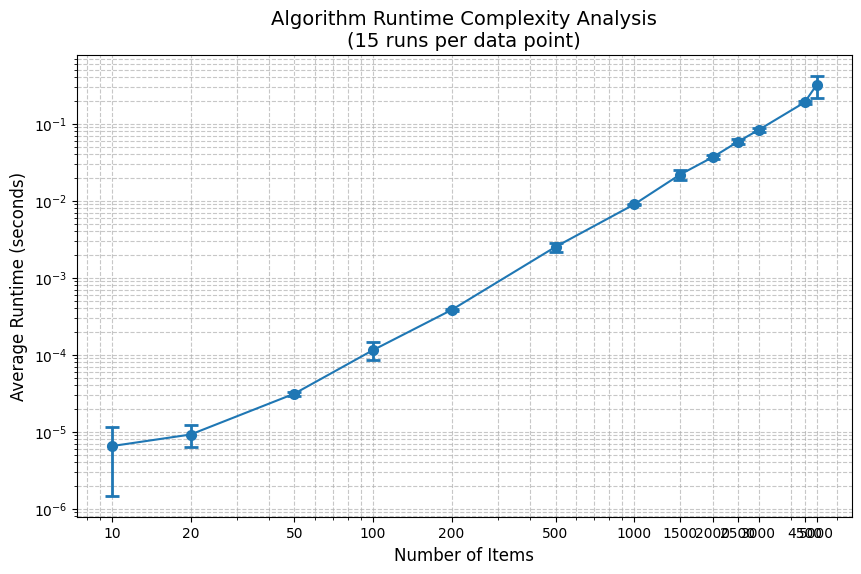

In [14]:
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import random

def measure_performance():
    sizes = [10, 20, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 4500, 5000] 
    runs_per_size = 15                            
    epsilon = 0.01

    avg_times = []
    std_devs = []

    for size in sizes:
        run_times = []
        print(f"Testing size {size}...")

        for _ in range(runs_per_size):
            items = generate_test_case(size)

            solver = PTAS(items, epsilon)

            start_time = time.time()
            solver.solve()
            end_time = time.time()

            run_times.append(end_time - start_time)

        avg_times.append(np.mean(run_times))
        std_devs.append(np.std(run_times))

    plt.figure(figsize=(10, 6))
    plt.errorbar(sizes, avg_times, yerr=std_devs, fmt='-o',
                capsize=5, elinewidth=2, markeredgewidth=2)
    plt.xlabel('Number of Items', fontsize=12)
    plt.ylabel('Average Runtime (seconds)', fontsize=12)
    plt.title('Algorithm Runtime Complexity Analysis', fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xticks(sizes, labels=[str(s) for s in sizes])
    plt.show()

measure_performance()